In [1]:
import os
import time
import random
import sys  
import matplotlib.pyplot as plt
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import classification_report
import torchvision.transforms as T
import cv2


In [2]:
ROOT_DIR = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "../"))
if ROOT_DIR not in sys.path:
    sys.path.insert(0, ROOT_DIR)
print(ROOT_DIR)

from src.model.paddleocr import OCRModule
from src.transform.custom_transform_ratio import get_augraphy_transform, get_transform_norm_tensor, get_transform_rotation
from src.utils.pil import denormalize

/root/upstageailab-cv-classification-cv_7


In [3]:
def show_images_with_preds(img_list, n_cols=4):
    n_imgs = len(img_list)
    n_rows = (n_imgs + n_cols - 1) // n_cols

    plt.figure(figsize=(n_cols * 4, n_rows * 4))

    for i, img_str in enumerate(img_list):
        img = Image.open(img_str)

        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(img)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [4]:
def show_tensor_images(tensor_images, titles=None, cols=4, clamp=True):
    """
    텐서 이미지 리스트를 시각화하는 함수

    Args:
        tensor_images (list of torch.Tensor): 시각화할 이미지 텐서 리스트
        titles (list of str, optional): 각 이미지에 대한 제목
        cols (int): 한 줄에 출력할 이미지 개수
        clamp (bool): 이미지 픽셀값을 [0, 1]로 제한할지 여부
    """
    to_pil = T.ToPILImage()
    rows = (len(tensor_images) + cols - 1) // cols
    plt.figure(figsize=(4 * cols, 4 * rows))
    
    for i, image_tensor in enumerate(tensor_images):
        plt.subplot(rows, cols, i + 1)
        if clamp:
            image_tensor = image_tensor.clamp(0, 1)
        plt.imshow(to_pil(image_tensor))
        if titles and i < len(titles):
            plt.title(titles[i])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


In [5]:
import cv2
import numpy as np

def get_rotation_angle_from_numpy(image):
    """
    이미지(NumPy 배열)의 회전 각도를 추출하는 함수

    Args:
        image (np.ndarray): 분석할 이미지 (OpenCV로 읽은 BGR 형식의 NumPy 배열)

    Returns:
        float: 계산된 회전 각도 (단위: 도)
    """

    image = image.cpu().numpy()

    # (C, H, W) → (H, W, C)로 변환
    if image.shape[0] in [1, 3]:  # 채널이 첫 번째 축이면
        image = np.transpose(image, (1, 2, 0))

    # uint8 타입으로 변환 (필요시)
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    # 1. 전처리 (이미지가 이미 NumPy 배열이므로 읽기 과정이 필요 없음)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 가우시안 블러로 노이즈 제거
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # 이진화 (Threshold)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # 2. 윤곽선 찾기
    contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # 3. 가장 큰 윤곽선 찾기
    if not contours:
        print("윤곽선을 찾을 수 없습니다.")
        return 0
        
    largest_contour = max(contours, key=cv2.contourArea)

    # 4. 최소 영역 사각형으로 각도 계산
    rect = cv2.minAreaRect(largest_contour)
    angle = rect[-1]

    # 5. 각도 보정
    if rect[1][0] < rect[1][1]:
        angle = angle + 90
    
    if angle < -45:
        angle = 90 + angle

    return angle

def rotate_with_albumentations(image, angle):
    """
    Albumentations를 이용해 이미지를 회전시키는 함수
    - angle: 시계 반대 방향(positive가 counter-clockwise)
    """
    # image: (C, H, W) → (H, W, C)
    if image.shape[0] in [1, 3]:
        image = np.transpose(image.cpu().numpy(), (1, 2, 0))

    transform = A.Compose([
        A.Rotate(limit=(angle, angle), border_mode=cv2.BORDER_CONSTANT, fill=(255, 255, 255), interpolation=cv2.INTER_LINEAR, p=1)
    ])

    augmented = transform(image=image)
    rotated_image = augmented["image"]

    rotated_tensor = torch.from_numpy(rotated_image).permute(2, 0, 1)

    return rotated_tensor


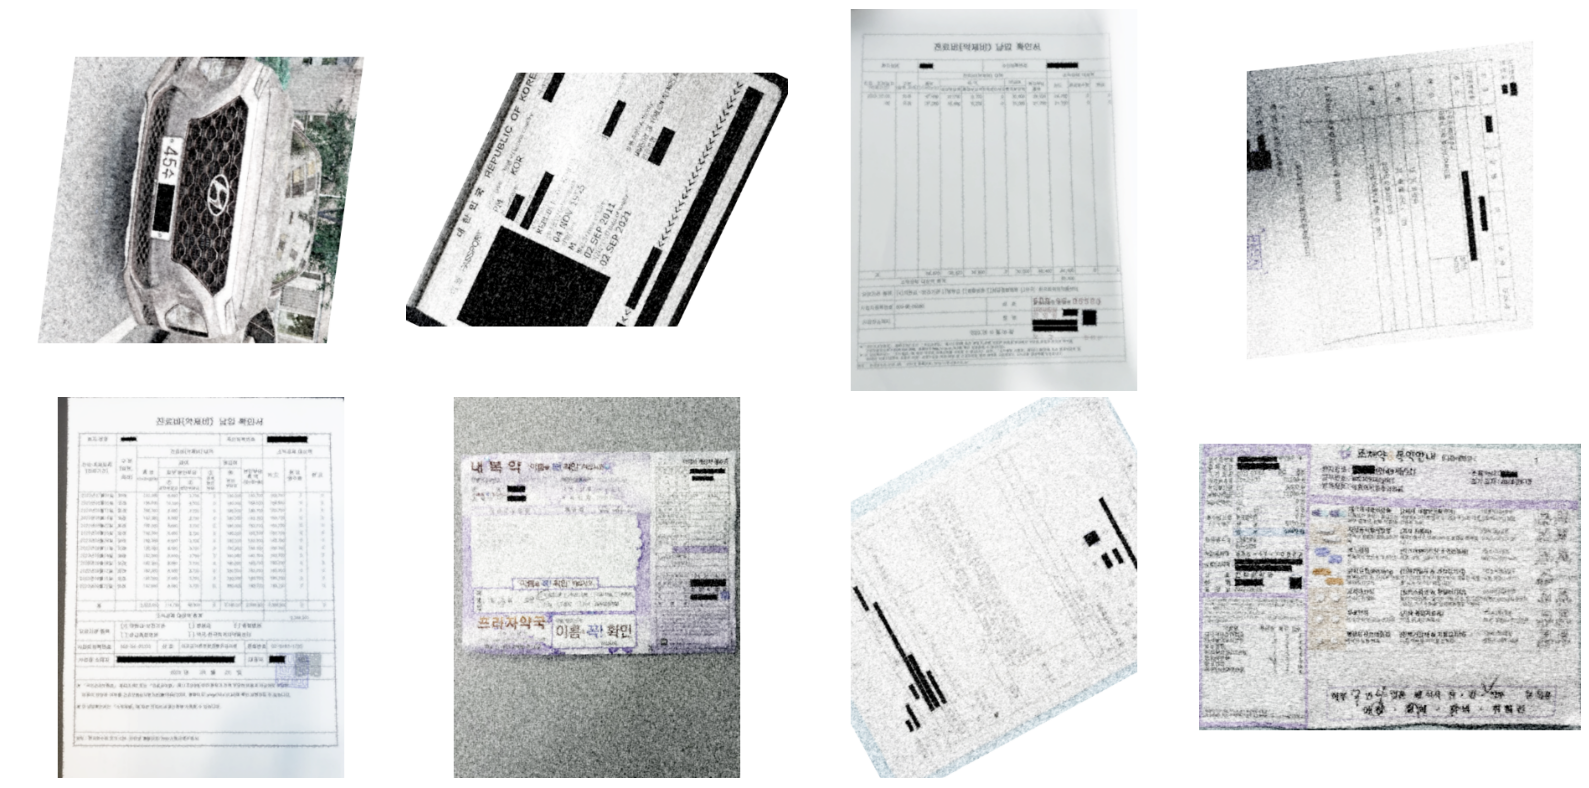

In [6]:
data_path = "./../../data/train"
img_list = np.array(os.listdir(data_path))

imgs = img_list[np.random.choice(len(img_list), size=8, replace=False)]
img_paths = [os.path.join(data_path, img) for img in imgs]
images = [np.array(Image.open(img_path).convert("RGB")) for img_path in img_paths]

aug_pipeline = get_augraphy_transform()
al_transform = [get_transform_rotation(p=0.3), get_transform_norm_tensor(image_size=(456, 456))]

images_aug = [aug_pipeline(image) for image in images]
for transform in al_transform:
    images_aug = [transform(image=image)['image'] for image in images_aug]

images_aug = [denormalize(image) for image in images_aug]
show_tensor_images(images_aug)



TypeError: Invalid shape (3, 456, 456) for image data

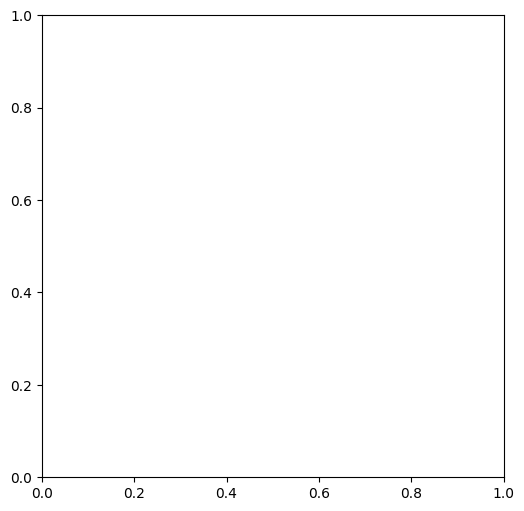

In [7]:
import matplotlib.pyplot as plt

idx = 4
rotated_image = rotate_with_albumentations(images_aug[idx], get_rotation_angle_from_numpy(images_aug[idx]))  # image_tensor는 torch.Tensor


plt.figure(figsize=(6, 6))
plt.imshow(rotated_image)
plt.axis("off")
plt.title(f"Rotated {get_rotation_angle_from_numpy(images_aug[idx])} degrees")
plt.show()


In [36]:
import cv2
import numpy as np

import numpy as np
import cv2
import torch
from bm3d import bm3d, BM3DProfile


def denoise_and_contrast_enhance(
    image: torch.Tensor,
    h: float = 2.0,
    h_color: float = 3.0,
    template_window_size: int = 7,
    search_window_size: int = 15,
    clip_limit: float = 2.0,
    tile_grid_size: tuple = (8, 8)
) -> np.ndarray:
    """
    이미지 디노이즈 및 대비 향상

    Args:
        image (torch.Tensor): 입력 이미지 (C,H,W)
        use_bm3d (bool): BM3D 사용 여부
        bm3d_sigma (float): BM3D에 사용할 sigma 값 (0~1)
        나머지는 OpenCV 디노이징 및 CLAHE 설정

    Returns:
        np.ndarray: 처리된 RGB 이미지 (np.uint8)
    """
    # 1. 텐서를 numpy RGB 이미지로 변환
    img = image.cpu().numpy()  # (C,H,W)
    if img.shape[0] == 1:
        img = np.repeat(img, 3, axis=0)  # (1,H,W) → (3,H,W)
    img = np.transpose(img, (1, 2, 0))  # (C,H,W) → (H,W,C)

    # float32 [0,1] 로 정규화된 경우 → uint8 [0,255]
    if img.dtype != np.uint8:
        img = np.clip(img * 255.0, 0, 255).astype(np.uint8)

    # 2. 디노이징
    
    img = cv2.fastNlMeansDenoisingColored(
        img,
        h=h,
        hColor=h_color,
        templateWindowSize=template_window_size,
        searchWindowSize=search_window_size
    )

    # 3. 대비 향상 (CLAHE)
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    l_clahe = clahe.apply(l)
    lab_enhanced = cv2.merge((l_clahe, a, b))
    enhanced_bgr = cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2BGR)
    enhanced_rgb = cv2.cvtColor(enhanced_bgr, cv2.COLOR_BGR2RGB)

    return enhanced_rgb



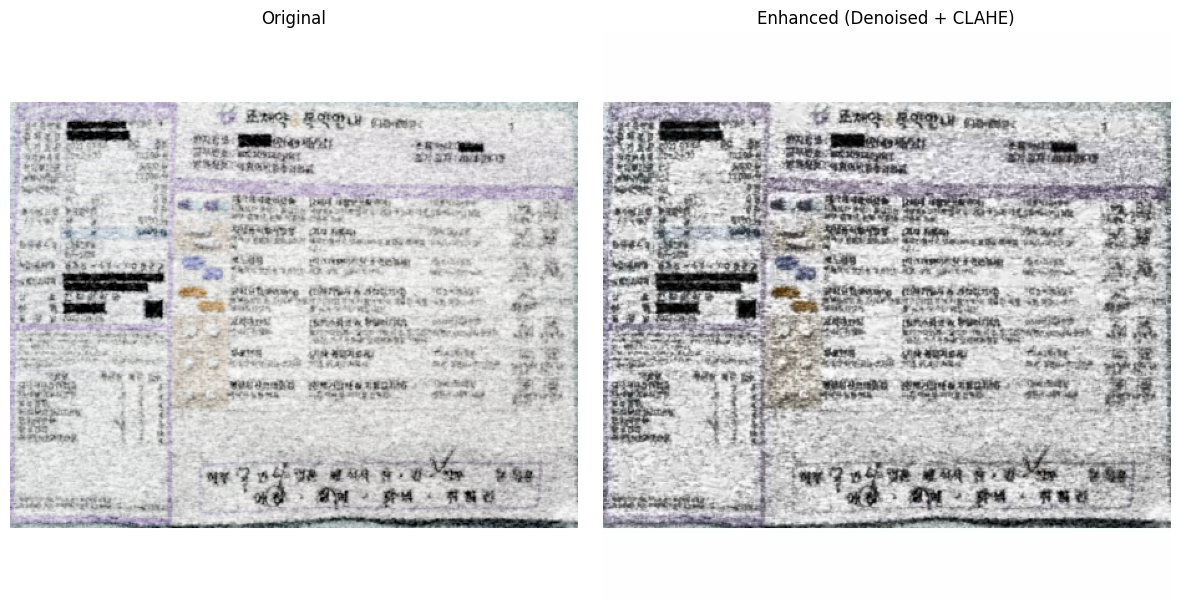

In [46]:
idx = 7

# 함수가 enhanced만 반환 중이면 수정 필요
enhanced = denoise_and_contrast_enhance(images_aug[idx])
original_img = images_aug[idx].permute(1, 2, 0).cpu().numpy()

# 정규화 범위 확인 후 0~255 변환 (필요 시)
if original_img.max() <= 1.0:
    original_img = (original_img * 255).astype(np.uint8)

plt.figure(figsize=(12, 6))

# 원본 이미지
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original")
plt.axis("off")

# 디노이즈 + 대비 향상 이미지
plt.subplot(1, 2, 2)
plt.imshow(enhanced)
plt.title("Enhanced (Denoised + CLAHE)")
plt.axis("off")

plt.tight_layout()
plt.show()


In [199]:
images_aug = [rotate_with_albumentations(image, get_rotation_angle_from_numpy(image)) for image in images_aug]

In [ ]:
OCR = OCRModule()

Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in /data/ephemeral/home/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('UVDoc', None)
Using official model (UVDoc), the model files will be automatically downloaded and saved in /data/ephemeral/home/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in /data/ephemeral/home/.paddlex/official_models.


Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in /data/ephemeral/home/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('korean_PP-OCRv5_mobile_rec', None)
Using official model (korean_PP-OCRv5_mobile_rec), the model files will be automatically downloaded and saved in /data/ephemeral/home/.paddlex/official_models.


In [200]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_tensor_batch = torch.stack(images_aug).to(device)
result = OCR.run_ocr(img_tensor_batch)

In [218]:
for res in result:
  display(res['rec_texts'])

['0-91029', '!']

[]

['-']

['진', '단', '선']

['2이',
 '영수번호',
 'GG',
 '9-11',
 '10 15 31',
 '02(',
 '01(',
 '18',
 '2',
 '(2',
 '201',
 '347.220',
 '2',
 'o  ocCn',
 '34.220',
 '영수',
 '가',
 'F',
 '0',
 '수',
 '9',
 '2',
 '34220',
 '347.220',
 '신',
 '사업자호',
 '61063F1506',
 '9',
 '사업장',
 '소재지',
 '/영수의인 9',
 'MA',
 ' ',
 'A0',
 '2',
 'O',
 '정에수',
 '  126',
 'fout ax r',
 '22']

['최', 'I', '위무/', '1013-108-2']

['2종보통',
 '지자운전연어를(DriversLiecnse)',
 '성문',
 '890611',
 '강원도순천사',
 '변하',
 '2029.01.01',
 '갱산기간',
 '2029.12.31.',
 '조건',
 '2019.12.16.강원지방경찰형장']

['자동차품속중', ' ', '00', '불산망의사장방동하자업소', 'A', '2', 'g']

In [234]:
vocab = set(['진단서','영수번호']) 

def segment(text, vocab, max_len=10):
    n = len(text)
    dp = [(-1e9, None)] * (n+1)
    dp[0] = (0, [])
    for i in range(n):
        if dp[i][0] < -1e8: continue
        # 최대 길이만큼 뒤로 탐색
        for l in range(1, min(max_len, n-i)+1):
            word = text[i:i+l]
            score = dp[i][0] + (1 if word in vocab else -1)
            if score > dp[i+l][0]:
                dp[i+l] = (score, dp[i][1] + [word])
    return dp[n][1]

chars = ['진','단','선']
text = ''.join(chars)                  # "진단선"
words = segment(text, vocab)           # ["진단서"] 로 매칭되게, 사전에 '진단서'가 있어야 함

In [235]:
words

['진단선']

In [208]:
from keybert import KeyBERT

model = KeyBERT('distilbert-base-nli-mean-tokens')

In [2]:
from soynlp.tokenizer import LTokenizer
tokenizer = LTokenizer()
print(tokenizer.tokenize("진단서기타"))


['진단서기타']


In [236]:
doc = ''.join(result[4]['rec_texts'])

keywords = model.extract_keywords(doc, keyphrase_ngram_range=(1, 2), stop_words=None, top_n=5)
print(keywords)

[('220영수가f0수9234220347 220신사업자호61063f15069사업장소재지', 0.9514), ('220신사업자호61063f15069사업장소재지 영수의인', 0.9386), ('220신사업자호61063f15069사업장소재지', 0.9284), ('occn34 220영수가f0수9234220347', 0.861), ('220영수가f0수9234220347', 0.8505)]
